In [2]:
from dask.distributed import Client, LocalCluster
import dask.array as da
import dask
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA as IPCA
from sklearn.cluster import KMeans

import numpy as np
import xarray as xr
import rioxarray
from numba import jit

import matplotlib.pyplot as plt

import os
import random
from time import time

# launch a scheduler and workers locally
cluster = LocalCluster()

# connect to cluster
client = Client(cluster)

client

distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-esllxdot', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-y4ssoowy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-h_37jfef', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-k6njg3tz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-_lqde2lp', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/michael/Work/NEON/dask-worker-space/worker-6l8lchdh', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 31.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44379,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 31.21 GiB
Comm: tcp://127.0.0.1:40621,Total threads: 4
Dashboard: http://127.0.0.1:38047/status,Memory: 5.20 GiB
Nanny: tcp://127.0.0.1:32997,


## Training the scaler

First we will use pixels sampled from the full data set  to create a train and determine parameters for the StandardScaler.

In [3]:
@jit
def resh(arr, dim):
    '''reshapes from 3d (x,y,wl) to 2d (x*y,wl)'''
    arr = arr.reshape(-1, dim)
    return arr


def train_scaler_multi_nc(files, variable, size=0.025):
    '''
    Returns a sklearn StandardScaler, and PCA instnace trained on a random sample drawn from 
    variable found within netcdf4s in a list of files, as well as the scaled data.  Curently assumes
    variable is a 3D array.
    
    arg:
        files    - list of full paths to netcdf4 files to be used.
        variable - variable from within dataset of interest. 
        size     - fraction of data to be used.
    '''
    
    # open all the files in a lazy way
    data = xr.open_mfdataset(files)

    # generate indices to randomply sample pixels
    xs = random.sample(range(data.x.shape[0]), int(data.x.shape[0] * size))
    ys = random.sample(range(data.y.shape[0]), int(data.y.shape[0] * size))
    xs.sort()

    # get wl dimension size
    wl = data[variable].shape[2]

    # extract the sample and switch to numpy
    refl = np.array(data.isel(x=xs, y=ys)[variable].data)

    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]

    # scale the data
    scaler = StandardScaler().fit(flat_refl)
    scaled_refl = scaler.transform(flat_refl)

    # instantiate the PCA thingy
    pca = PCA()

    # fit the pca model
    pca.fit(scaled_refl)

    
    return(scaler, pca, scaled_refl)


def plot_pca_var(pca):
    '''plots explained variance by PCA component'''
    
    # make fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, 359),
             pca.explained_variance_ratio_.cumsum(),
             marker='o',
             linestyle='--');
    
    # details
    plt.title('Explained Variance by Number of Components');
    plt.xlabel('Components');
    plt.ylabel('Cumulative explained Var');
    plt.xlim(0, 20);
    plt.show()


def kmeans_wcss(n_components, scaled_refl, max_n_clusters=20):
    '''
    Returns a list of wcss values for different n_clusters values
    after performing PCA using n_components.
    args:
        n_components   - number of components to be kept in PCA.
        scaled_refl    - scaled values on which to perform PCA and
                         clustering.
        max_n_clusters - max number of clusters to try default 20.
    '''
    # use two components for pca
    pca = PCA(n_components=n_components)

    # fit
    pca.fit(scaled_refl)

    # get component scores
    scores_pca = pca.transform(scaled_refl)

    # empty list for witih cluster sum of squares
    wcss = []

    # now try out some differnt cluster numbers
    print(f'Out of {max_n_clusters} trials working on:')

    for n in range(1, max_n_clusters + 1):
        
        print(f'\b\b{n}', end="")
        
        kmeans =  KMeans(n_clusters=n, init='k-means++', random_state=42)
        kmeans.fit(scores_pca)
        wcss.append(kmeans.inertia_)

    print('\ndone!')
    
    return wcss


def plot_wcss(wcss):
    '''plots wcss vs n_clusters'''
    
    # fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, len(wcss) + 1),
             wcss,
             marker='o',
             linestyle='--');

    # details
    plt.title('Kmeans with PCA WCSS');
    plt.xlabel('WCSS');
    plt.ylabel('Number of Clusters');



In [4]:
# path and sitename
site = 'TALL'
path = f'/media/data/NEON/{site}'
data = f'{path}/hyperspectral/DP3.30006.001/2021/FullSite/D08/2021_TALL_6/L3/Spectrometer/Reflectance'

# chunksize in bytes
chunksize = 4_000_000_000

# find the filenames
files = [os.path.join(data, f)
         for f
         in os.listdir(data)
         if '.nc' in f
         and site in f]

# train the scaler on a sample
scaler, pca, scaled_refl = train_scaler_multi_nc(files, 'reflectance')

/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]


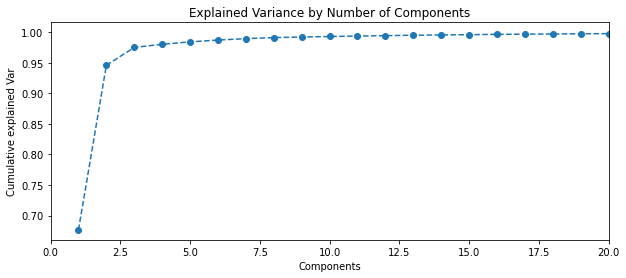

In [5]:
plot_pca_var(pca)

From the figure above we can see that two components explain well over 8-% of the variance. Thus we will use two components. Now from the sample we need to determine the number of clusters to use.

Out of 10 trials working on:
10
done!


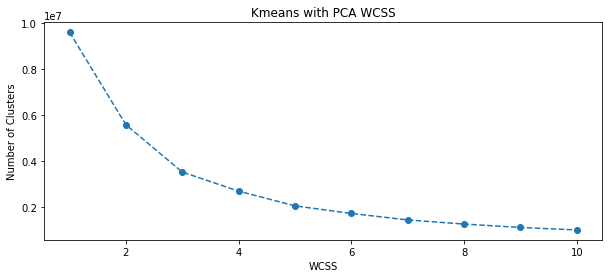

In [6]:
# 2 components as discussed above
n_components = 2

# get wcss for different n_clusters
wcss = kmeans_wcss(n_components, scaled_refl, max_n_clusters=10)

# plot
plot_wcss(wcss)

Using the "elbow rule" we will choose 3 clusters.

In [7]:
# 3 clusters as discussed above
n_clusters = 3

## PCA and clustering on full data

Due to the size of the dataset we will need to use incremental PCA (IPCA) chunk by chunk on the dataset.

In [8]:
# instantiate IPCA
ipca = IPCA(n_components=n_components)

# make a generator to extract reflectances file by file
refl_gen = (xr.open_dataset(f) for f in files)

# for each file
print('fitting IPCA')
print(f'Out of {len(files)} on:')
i = 1

for xarr in refl_gen:
    # print progress
    print(f'\b\b{i}', end="")
    i = i + 1
    
    # get wl dimension size
    wl = xarr['reflectance'].shape[2]
    
    # extract the sample as np array
    refl = np.array(xarr['reflectance'].data)  
    
    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]
    
    # scale with previously fit scaler
    #scaler = StandardScaler().fit(flat_refl)
    scaled = scaler.transform(flat_refl)
    
    # partially fit the ipca
    ipca.partial_fit(scaled)

fitting IPCA
Out of 49 on:
49

In [ ]:

import rasterio as rio
from rasterio.merge import merge

In [ ]:
# reinitialize generator, this time with basename
refl_gen = ((xr.open_dataset(f), os.path.basename(f).split('.')[0]) for f in files)

# ensure directory for tiffs exists and make path
pca_house = os.path.join(path, 'pca')
os.makedirs(pca_house, exist_ok=True)

# ensure directory for tiffs exists and make path
kmeans_house = os.path.join(path, 'kmeans')
os.makedirs(kmeans_house, exist_ok=True)

# for each file
print('\n\ngetting IPCA scores and clustering')
print(f'Out of {len(files)} on:')
i = 1

for xarr, base in refl_gen:
    # print progress
    print(f'\b\b{i}', end="")
    i = i + 1
    
    # get wl dimension size
    wl = xarr['reflectance'].shape[2]
    
    # extract the sample as np array
    refl = np.array(xarr['reflectance'].data)  
    
    # reshape
    flat_refl = resh(refl, wl)

    # before we drop nulls get their indices
    nan_idx = np.argwhere(
        (np.any(flat_refl == -9999, axis=1)) |
        (np.any(np.isnan(flat_refl), axis=1))
    )
    
    # replace nulls with average columns
    s = flat_refl.shape
    
    #condition = (~np.any(flat_refl == -9999, axis=1)) & (~np.any(np.isnan(flat_refl), axis=1))

    #mean_column = flat_refl.mean(axis=0)

    #flat_refl[condition] = mean_column
    
    # scale with previously fit scaler
    scaled = scaler.transform(flat_refl)

    # get component scores
    scores_pca = ipca.transform(scaled)

     # put the no data values back in if there were any
    if np.any(nan_idx):
        scores_pca[nan_idx] = [-999] * n_components

    # add the scores to the xarray
    xarr['pca'] = xr.DataArray(scores_pca.reshape(1000, 1000, n_components), dims=['x', 'y', 'components'])

    # make fname
    tiff = os.path.join(pca_house, f'{base}_pca.tiff')
    
    # write the labels to geotiff
    xarr.pca.transpose('components', 'y', 'x').rio.to_raster(tiff)




getting IPCA scores and clustering
Out of 49 on:
1
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
2
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
3
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
4
nan_idx shape:(615014, 1)
(1000000, 358) vs (1000000, 358)
5
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
6
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
7
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
8
nan_idx shape:(631582, 1)
(1000000, 358) vs (1000000, 358)
9
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
10
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
11
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
12
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
13
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
14
nan_idx shape:(670498, 1)
(1000000, 358) vs (1000000, 358)
15
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
16
nan_idx shape:(0, 1)
(1000000, 358) vs (1000000, 358)
17
nan_idx shape:(0, 1)
(100000

In [ ]:
# paths and sitename (reiterated from above)
site = 'TALL'
path = f'/media/data/NEON/{site}'
data = f'{path}/hyperspectral/DP3.30006.001/2021/FullSite/D08/2021_TALL_6/L3/Spectrometer/Reflectance'
pca_house = os.path.join(path, 'pca')

# open all the pca tiffs
pca_tiffs = [os.path.join(pca_house, f) for f in os.listdir(pca_house) if 'full' not in f ]
pca_img = xr.open_mfdataset(pca_tiffs)

# write it all as one tiff
out_tiff = os.path.join(pca_house, f'{site}full_pca.tiff')
pca_img.band_data.rio.to_raster(out_tiff)

# flatten the pca img
comps = pca_img.band_data.shape[2]
flat_pca = resh(refl, comps)

In [ ]:

# cluster
kmeans =  KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans.fit(flat_pca)

# get labels
labels = kmeans.labels_

        
# add the labels to the xarray
pca_img['cluster'] = xr.DataArray(labels.reshape(1000, 1000), dims=['x', 'y'])

# make fname
tiff = os.path.join(kmeans_house, f'{base}_kmeans.tiff')

# write the labels to geotiff
xarr.cluster.transpose('y', 'x').rio.to_raster(tiff)

In [ ]:
print('done')

In [ ]:
@jit
def resh(arr, dim):
    '''reshapes from 3d (x,y,wl) to 2d (x*y,wl)'''
    arr = arr.reshape(-1, dim)
    return arr


def scale_scaler_and_pca(refl, wl):
    '''
    returns the flattened scaled data,
    the trained scaler,
    and the fit pca model
    '''
    
    # reshape
    flat_refl = resh(refl, wl)

    # drop nulls
    flat_refl = flat_refl[
        (~da.any(flat_refl == -9999, axis=1)) &
        (~da.any(da.isnan(flat_refl), axis=1))]

    # scale the data
    scaler = StandardScaler().fit(flat_refl)
    scaled_refl = scaler.transform(flat_refl)

    # instantiate the PCA thingy
    pca = PCA()

    # fit the pca model
    pca.fit(scaled_refl)

    return(scaled_refl, scaler, pca)


def plot_pca_var(pca):
    '''plots explained variance by PCA component'''
    
    # make fig
    plt.figure(figsize=(10,4));

    # plot
    plt.plot(range(1, 359),
             pca.explained_variance_ratio_.cumsum(),
             marker='o',
             linestyle='--');
    
    # details
    plt.title('Explained Variance by Number of Components');
    plt.xlabel('Components');
    plt.ylabel('Cumulative explained Var');
    plt.xlim(0, 20);
    plt.show()

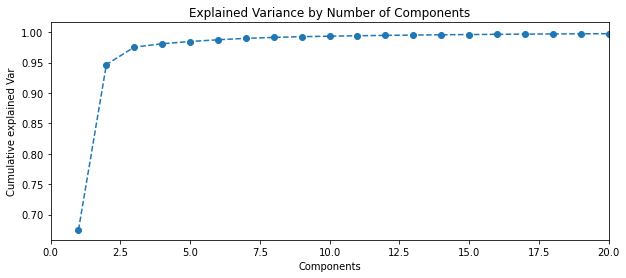

In [ ]:
# train the scaler and pca and scale data
scaled_refl, scaler, pca = scale_scaler_and_pca(refl, wl)

# plot
plot_pca_var(pca)

The decline is much steeper through the first threee points then smooths out.  So the "elbow method" suggests we use 3 clusters.

## Clustering the data
We will have to cycle through the data sets and cluster for memory sake. We ill use two proncipal components and three kmeans clusters as decided above.

In [ ]:
# number of components for PCA to use
n_components = 2

# number os clusters
n = 3

print(f'Out of {len(files)} files working on number:')

for i, f in enumerate(files):    
    print(f'\b\b{i + 1}', end="")
    
    # get basename
    base = os.path.basename(f).split('.')[0]

    # open file
    xa = xr.open_dataset(f)
    arr = xa.reflectance.data

    # reshape
    flat = resh(arr, wl)

    # scale
    scaled = scaler.transform(flat)

    # use two components for pca
    pca = PCA(n_components=n_components)

    # fit
    pca.fit(scaled)

    # get component scores
    scores_pca = pca.transform(scaled)

    # cluster
    kmeans =  KMeans(n_clusters=n, init='k-means++', random_state=42)
    kmeans.fit(scores_pca)

    # get labels
    labels = kmeans.labels_

    # add the labels to the xarray
    xa['cluster'] = xr.DataArray(labels.reshape(1000, 1000), dims=['x', 'y'])


    # ensure directory for tiffs exists and make path
    tiff_house = os.path.join(path, 'kmeans')
    os.makedirs(tiff_house, exist_ok=True)
    tiff = os.path.join(tiff_house, f'{base}_kmeans.tiff')

    # write the labels to geotiff
    xa.cluster.transpose('y', 'x').rio.to_raster(tiff)

Out of 49 files working on number:
4

Exception in thread Profile:
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 115, in process
    d = state["children"][ident]
KeyError: 'write;/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/comm/tcp.py;245'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 274, in _watch
    process(frame, None, recent, omit=omit)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 119, in process
    "description": info_frame(frame)

11111111112222222222333334

Exception in thread Profile:
Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 115, in process
    d = state["children"][ident]
KeyError: 'write;/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/comm/tcp.py;245'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 274, in _watch
    process(frame, None, recent, omit=omit)
  File "/home/michael/miniconda3/envs/geo3/lib/python3.10/site-packages/distributed/profile.py", line 119, in process
    "description": info_frame(frame)

3333344444444449

(1000000, 2)